## OpenAI SLALOM

Run SLALOM with OpenAI models.

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
os.chdir("..")

## Load a test sample.

In [36]:
from transformers import AutoTokenizer
from transformers import GPT2TokenizerFast

tokenizer_gpt4 = GPT2TokenizerFast.from_pretrained('Xenova/gpt-4')
tokenizer_bert = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True, padding=512)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [32]:
res = tokenizer_gpt4.encode('hello world')

In [33]:
tokenizer_gpt4.decode(res)

'hello world'

In [377]:
import json

def load_tokens(file_name, stop_sep=False):
    mylist = []
    with open(file_name, 'r') as file:
        for line in file:
            if not stop_sep or ((line.strip("\n") != "[PAD]") and not ('<|endoftext|>' in line)):
                if (line.strip("\n") != "[CLS]") and (line.strip("\n") != "[SEP]"):
                     mylist.append(line.strip("\n"))
    return mylist

def convert_token_list_to_inputs(inp_list, tok):
    """ TODO: make more solid implementation. """
    return tok.convert_tokens_to_ids(inp_list)
    
tokens = load_tokens("datasets/sample_00002_bert.txt", stop_sep=True)
input_test = convert_token_list_to_inputs(tokens, tokenizer_bert)

input_text = tokenizer_bert.decode(input_test)
#input_text = input_text.replace("america", "russia")
input_gpt = tokenizer_gpt4.encode(input_text)
tres_list = torch.tensor(input_gpt)
unique_list, return_inverse = tres_list.unique(return_inverse=True)

In [378]:
input_text

'this movie was so frustrating. everything seemed energetic and i was totally prepared to have a good time. i at least thought i\'d be able to stand it. but, i was wrong. first, the weird looping? it was like watching " america\'s funniest home videos ". the damn parents. i hated them so much. the stereo - typical latino family? i need to speak with the person responsible for this. we need to have a talk. that little girl who was always hanging on someone? i just hated her and had to mention it. now, the final scene transcends, i must say. it\'s so gloriously bad and full of badness that it is a movie of its own. what crappy dancing. horrible and beautiful at once.'

In [379]:
from scripts.slalom_openai import OpenAImodel

In [586]:
target_model = "gpt-4" # "gpt-4-turbo"
myoai = OpenAImodel(target_model=target_model, tokenizer=tokenizer_gpt4)
init_score = myoai.forward(tres_list.reshape(1,-1), attention_mask = torch.ones_like(tres_list.reshape(1,-1)))
print(init_score)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

{'logits': tensor([[ 9.0361, -9.0361]])}


## Sample the dataset offline.

In [587]:
from slalom_explanations.slalom_helpers import sample_dataset

In [588]:
%%time
inps, bin_features, masks, outputs = sample_dataset(500, myoai, unique_list, tres_list.reshape(1, -1), use_cls=False, seq_len=2)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

CPU times: user 10.6 s, sys: 733 ms, total: 11.3 s
Wall time: 1min 13s


In [589]:
torch.save((inps, bin_features, masks, outputs), f"datasets/{target_model}_trainset_short.pt")

In [440]:
inps_d, bin_features_d, masks_d, outputs_d = sample_dataset(500, myoai, unique_list, tres_list.flatten(), use_cls=False, mode="deletion", max_deletions=5)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [441]:
torch.save((inps_d, bin_features_d, masks_d, outputs_d), f"datasets/{target_model}_trainset_deletion.pt")

## Fit SLALOM from offline dataset

In [525]:
from torch.optim import Adam
import math
def fit_slalom_offline(example_slalom_model, num_eps=10, lr=1e-3, dataset_returns=None, batch_size=256, return_steps=False):
    my_optim = Adam(example_slalom_model.parameters(), lr = lr)
    iters = 0
    inps_list, bin_list, mask_list, output_list = dataset_returns
    myds = torch.utils.data.TensorDataset(inps_list, mask_list, output_list)
    mydl = torch.utils.data.DataLoader(myds, batch_size = batch_size)
    subsize = len(mydl)
    val_list = []
    imps_list = []
    for ep in range(num_eps):
        losses = []
        my_dl_iter = iter(mydl)
        for i in range(subsize):
            try:
                inp_ids, mask, output = next(my_dl_iter)
            except StopIteration:
                break
            my_optim.zero_grad()
            output_slalom = example_slalom_model.forward(inp_ids.to(example_slalom_model.device))[:,1]
            loss = torch.sum(torch.pow(output-output_slalom, 2))
            loss.backward()
            my_optim.step()
            losses.append(math.sqrt(loss.item()/len(output)))
            iters += 1
        print(sum(losses))
        if ep % 3 == 2:
            val_list.append(example_slalom_model.my_values[1:].detach().clone())
            imps_list.append(example_slalom_model.my_importance[1:].detach().clone())
    if return_steps:
        return val_list, imps_list, example_slalom_model
    else:
        return val_list[-1], imps_list[-1], example_slalom_model

In [526]:
inps_d, bin_features_d, masks_d, outputs_d = dataset_returns

In [615]:
target_model = "gpt-4o-mini"
dataset_returns = torch.load(f"datasets/{target_model}_trainset_short.pt")
from slalom_explanations.slalom_helpers import MyLittleSLALOM
vinit = init_score["logits"][0, 1]*2
print(vinit)
#example_slalom_model = MyLittleSLALOM(unique_list, "cpu", v_init=vinit, pad_token_id=0)
example_slalom_model = MyLittleSLALOM(unique_list, "cpu", pad_token_id=0)
res_v, res_s, example_slalom_model = fit_slalom_offline(example_slalom_model, num_eps=80, lr=1e-2, dataset_returns=dataset_returns, batch_size=64)

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


tensor(-18.0721)
222.9358563102288
221.31497514076523
219.69257942078605
218.0376948292108
216.34594134001557
214.61893827488876
212.86291298001186
211.0869727461585
209.30092860361154
207.51359507418078
205.7318579434579
203.9605778201738
202.20286755867144
200.4605401176368
198.73454105268837
197.02525154466892
195.33272304786183
193.6568380597859
191.99737347975793
190.3540799786167
188.7266999685043
187.11500442566253
185.51875811160699
183.93775670633048
182.37180950533414
180.8207390782444
179.2843834698261
177.76259347950486
176.25522735067105
174.7621641200169
173.28327306374172
171.81844693460434
170.3675838527826
168.93057553904345
167.50732497649778
166.09773432049153
164.70169976659633
163.31913859313642
161.9499475867422
160.59403360622727
159.25129481755602
157.92164211257085
156.6049706796653
155.30117706944193
154.01015810013024
152.7318136833718
151.46602851394854
150.21269078542824
148.9716971355855
147.7429294370259
146.52628025461203
145.32164292934925
144.128918639

(array([113.,  51., 290., 442.,  43.,   8.,  22.,  12.,   9.,  10.]),
 array([-27.75      , -22.35000038, -16.95000076, -11.55000019,
         -6.1500001 ,  -0.75      ,   4.6500001 ,  10.05000019,
         15.44999981,  20.85000038,  26.25      ]),
 <BarContainer object of 10 artists>)

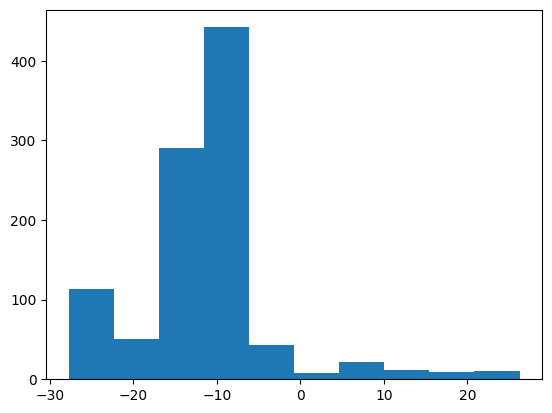

In [616]:
import matplotlib.pyplot as plt
plt.hist(dataset_returns[3])

In [617]:
return_inverse.shape

torch.Size([153])

In [618]:
res_lin = res_v*torch.exp(res_s)

In [619]:
res_lin = res_lin[return_inverse]
print(res_lin.shape)

torch.Size([153])


In [620]:
#res_lin = res_lin - res_lin.mean()

In [621]:
decoded_tokens = tokenizer_gpt4.convert_ids_to_tokens(input_gpt)

In [622]:
decoded_tokens = list([d.replace("Ġ", "") for d in decoded_tokens])

In [623]:
from matplotlib.colors import Normalize
import matplotlib as mpl
def visualize_attention(att_mat, decoded_tokens, start_pos_y, max_len=50, vmax=5):
    '''
    s_pos: from which token the attention should be visualized (usually the CLS token)
    start_pos_y: for visalizing multiple rows
    max_len: how many tokens should be visualized
    '''
    # average over all heads
    #att_mat = att_mat.sum(axis=1)/att_mat.shape[1]
    #cls_atts = np.flip(att_mat[:,s_pos], axis=0)
    cls_atts = att_mat[:max_len]


    fig, ax = plt.subplots(figsize=(7, 4.9))
    rend = fig.canvas.get_renderer()
    pos_x = 15
    max_x = 500
    pos_y = start_pos_y
    whitespace = 10
    norm = Normalize(vmin=-vmax, vmax=vmax)
    #cmap = plt.cm.YlOrRd
    #cmap = plt.cm.bwr
    cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["red","white","green"])
    plt.xlim([0, max_x+50])
    for token, att in zip(decoded_tokens, cls_atts):
        bb = dict(boxstyle="square, pad=0.2", fc=cmap(norm(att)), alpha=0.6)
        text = plt.text(pos_x, pos_y, token.replace("##", "").replace("Ġ", ""), color='black', bbox=bb, fontsize=12)
        pos_x += text.get_window_extent(renderer=rend).width + whitespace

        if pos_x > max_x:
            pos_x = 15
            pos_y -= 25
    plt.ylim([pos_y-40, start_pos_y+15])
    #cax = fig.add_axes([0.2, 0.0, 0.6, 0.05])  # Adjust these values as needed
    #cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal')
    #cb.set_label('Attention Score', fontsize=10)
    #cb.ax.tick_params(axis='both', labelsize=10)


    ax.set_facecolor('none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
    plt.show()
    return fig, ax

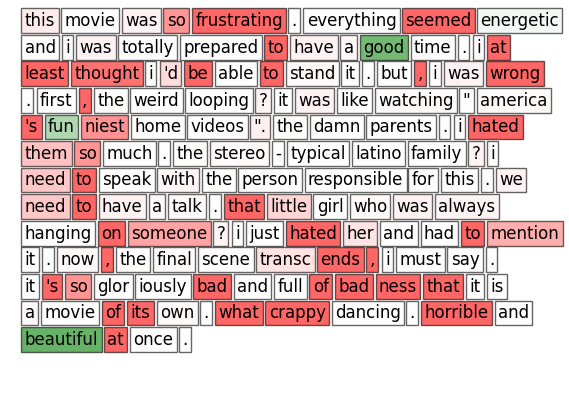

In [625]:
import matplotlib.pyplot as plt
f, ax = visualize_attention(res_lin.flatten(), decoded_tokens, start_pos_y=500, max_len=200, vmax=100)

In [626]:
f.savefig("figures/slalom_gpt4o_mini.pdf")